In [1]:
# Uplift experiment

In [2]:
# Import libs
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

import requests
import io

In [3]:
# Import data, source and description: https://ailab.criteo.com/criteo-uplift-prediction-dataset/

# Pointer to file, download, and check if successful
url = "http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz"
response = requests.get(url)
response.raise_for_status()

# Unzip and read file to data frame
df = pd.read_csv(io.BytesIO(response.content), compression='gzip')

df.head(5)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [5]:
# Check target variables
df['treatment'].value_counts(normalize = True)

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64

In [6]:
df['conversion'].value_counts(normalize = True)

conversion
0    0.997083
1    0.002917
Name: proportion, dtype: float64

In [7]:
# Take 10% sample to speed up things...
sample_df = df.sample(frac=0.1, random_state=1)

In [8]:
# Define features, treatment, response
X = sample_df[['f0', 'f1', 'f2', 'f3']]
T = sample_df['treatment']
Y = sample_df['conversion']

# Split data to training and testing
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3, random_state=42)

In [9]:
# Build uplift model using two-model approach
# Model 1, treatment group
treatment_model = GradientBoostingClassifier()
treatment_model.fit(X_train[T_train == 1], Y_train[T_train == 1])

# Model 2, control group
control_model = GradientBoostingClassifier()
control_model.fit(X_train[T_train == 0], Y_train[T_train == 0])

GradientBoostingClassifier()

In [10]:
# Predict probabilities
treatment_proba = treatment_model.predict_proba(X_test)[:, 1]
control_proba = control_model.predict_proba(X_test)[:, 1]

# Calculate uplift
uplift = treatment_proba - control_proba

In [14]:
# Add uplift scores to customers
result = X_test.copy()
result['Uplift'] = uplift

In [15]:
print(result)

                 f0         f1        f2        f3    Uplift
4264162   25.901424  10.059654  8.214383  4.679882 -0.000036
2945016   26.147379  10.059654  8.214383  4.679882 -0.000036
11723510  22.713823  10.059654  8.214383  4.679882 -0.000036
7808031   26.362339  10.059654  9.029289  4.679882  0.000297
11700653  25.084630  10.059654  8.214383  4.679882 -0.000036
...             ...        ...       ...       ...       ...
13066441  21.985488  10.059654  8.640628  4.679882  0.001326
5701053   25.800536  10.059654  8.214383  4.679882 -0.000036
5220619   24.518276  10.059654  8.953918  4.679882  0.000347
3643570   13.201089  10.059654  8.214383  3.907662 -0.000060
11190620  17.255607  10.059654  8.214383  1.114982  0.000052

[419388 rows x 5 columns]


In [19]:
# Validation needs work tbd...

/tmp/ipykernel_11599/2697318753.py:15: RuntimeWarning: invalid value encountered in divide
  cum_gain_control = np.cumsum(y_true_sorted * (1 - treatment_sorted)) / n_control


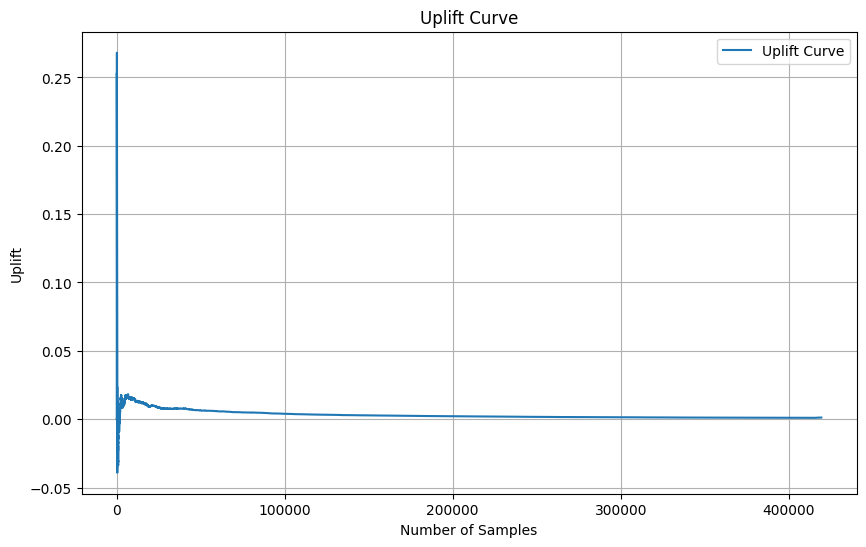

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_uplift_curve(y_true, uplift, treatment):
    # Sort by uplift scores
    sorted_indices = np.argsort(uplift)[::-1]
    y_true_sorted = y_true[sorted_indices]
    treatment_sorted = treatment[sorted_indices]

    # Calculate cumulative gains for treatment and control groups
    n_treatment = np.cumsum(treatment_sorted)
    n_control = np.cumsum(1 - treatment_sorted)
    cum_gain_treatment = np.cumsum(y_true_sorted * treatment_sorted) / n_treatment
    cum_gain_control = np.cumsum(y_true_sorted * (1 - treatment_sorted)) / n_control

    # Calculate uplift curve
    uplift_curve = cum_gain_treatment - cum_gain_control

    # Plot uplift curve
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(uplift_curve)), uplift_curve, label='Uplift Curve')
    plt.xlabel('Number of Samples')
    plt.ylabel('Uplift')
    plt.title('Uplift Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming Y_test, uplift, and T_test are already defined
plot_uplift_curve(Y_test.values, uplift, T_test.values)
